In [1]:
# depth_mapping_prototypbe.ipynb

# Python notebook for prototyping implementation of 3D depth mapping algorithm from the following paper:
# J. Wlodek, K. J. Gofron, Y. Q. Cai; Achieving 3D imaging through focus stacking.
# AIP Conf. Proc. 15 January 2019; 2054 (1): 050001. https://doi.org/10.1063/1.5084619

# Bennett Wu - 11/17/2023
# Last Updated - 12/3/2023

import os
import math
import numpy as np
import matplotlib.pyplot as plt
import skimage
import cv2

In [2]:
def normalize_array(arr: np.array, uint8_mode=False) -> np.array:
    '''
    Normalizes numpy array to be float32 with range 0-1 or uint8 with range 0-255

    arr - array to normalize
    uint8_mode - select float32 or uint8, defaults to float32

    returns - uint8 or float32 numpy array in same shape as input
    '''
    arr = arr.astype('float32')
    if np.max(arr) - np.min(arr) == 0:
        return arr
    arr = (arr - np.min(arr)) / (np.max(arr) - np.min(arr))
    if uint8_mode:
        arr *= 255
        arr = arr.astype('uint8')
    return arr


def load_image(path: os.PathLike) -> np.array:
    '''
    Loads a given image in RGB from given path

    path - path to image

    returns - float32 numpy array representing an RGB image
    '''
    try:
        bgr_img = cv2.imread(path)
        rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
        return normalize_array(rgb_img)
    except:
        raise Exception(f'Failed to load image: {path}')


def rgb_to_gray(im: np.array) -> np.array:
    '''
    Converts a RGB image to grayscale

    im - image to convert

    returns - numpy array representing a grayscale image
    '''
    assert len(im.shape) == 3  # Image must be RGB
    return cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)


def plt_img(ax: plt.axis, img: np.array, title='') -> None:
    '''
    Plots given image onto matplot axis with an optional title

    ax - matplot plot axis (can just pass in matplot.pyplot, or a subplot axis)
    img - grayscale or RGB image to plot
    title - optional plot title
    '''
    cmap = 'gray'
    if (len(img.shape) == 3 and img.shape[2] == 3):
        cmap = None
    ax.imshow(img, cmap=cmap)
    ax.axis('off')
    if title:
        ax.set_title(title)


def save_fig(path: os.PathLike, fig: plt.Figure) -> None:
    '''
    Saves given plot to given path.

    path - path to save plot to
    img - image to save
    '''
    path = os.path.abspath(path)
    os.makedirs(os.path.dirname(path), exist_ok=True)
    fig.savefig(path, bbox_inches='tight')
    print(f"Image saved at {path}")


def save_img(path: os.PathLike, img: np.array) -> None:
    '''
    Saves given image to given path. Converts non uint8 images to uint8

    path - path to save image to
    img - image to save
    '''
    if (len(img.shape) == 3):
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    if (img.dtype != 'uint8'):
        img = normalize_array(img, uint8_mode=True)

    # Ensure output directory exists
    path = os.path.abspath(path)
    os.makedirs(os.path.dirname(path), exist_ok=True)
    cv2.imwrite(path, img)
    print(f"Image saved at {path}")

In [3]:
# Load images to stack and input focal depths
img_dir = '../source_images/bug'
img_names = [
    # 'b_bigbug0001_croppped.png', 'b_bigbug0002_croppped.png', 'b_bigbug0003_croppped.png', 'b_bigbug0004_croppped.png', 
    # 'b_bigbug0005_croppped.png', 'b_bigbug0006_croppped.png', 'b_bigbug0007_croppped.png', 'b_bigbug0008_croppped.png', 
    # 'b_bigbug0009_croppped.png', 'b_bigbug0010_croppped.png', 'b_bigbug0011_croppped.png', 'b_bigbug0012_croppped.png'
    'hf001.jpg','hf005.jpg','hf010.jpg','hf015.jpg',
    'hf020.jpg','hf025.jpg','hf030.jpg','hf035.jpg',
]

focal_depths = np.array([
    # 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12
    1, 5, 10, 15, 20, 25, 30, 35
])

images = np.array([
    load_image(os.path.join(img_dir, name)) for name in img_names
])


In [4]:
# Select an image for testing
test_img = images[3]

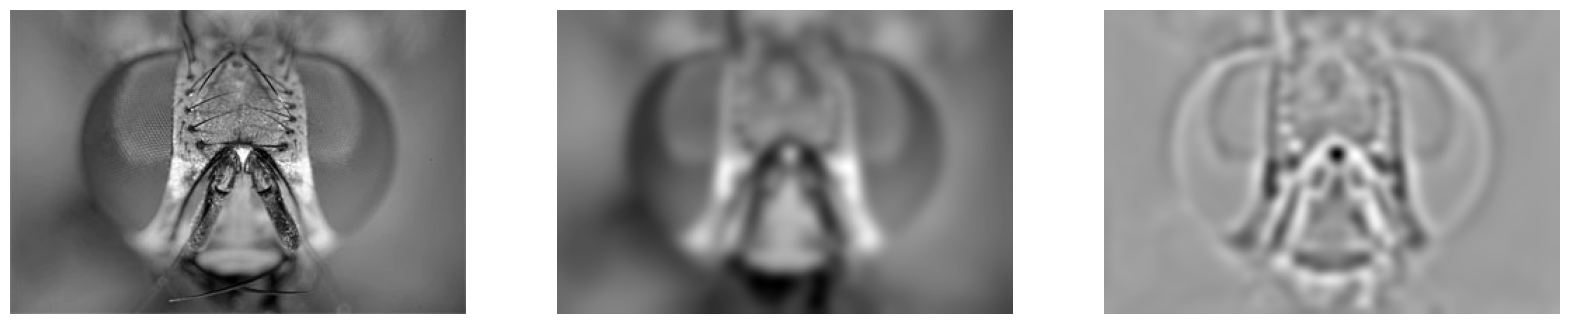

In [5]:
def gauss_convolve(im: np.array, ksize: int) -> np.array:
    '''
    Convolves given image using a gaussian kernel

    im - image to blur
    ksize - Size in pixels of gaussian kernel. Must be odd.

    returns - numpy array of convolved image
    '''
    # ksize must be odd
    assert ksize % 2 == 1
    # Grayscale or RGB images allowed
    assert len(im.shape) == 2 or len(im.shape) == 3

    return cv2.GaussianBlur(im, (ksize, ksize), 0)


def laplacian_convolve(im: np.array, ksize: int) -> np.array:
    '''
    Convolves given image using a laplacian kernel

    im - image to convolve
    ksize - Size in pixels of laplacian kernel. Must be odd.

    returns - numpy array of convolved image
    '''
    # ksize must be odd
    assert ksize % 2 == 1
    # Grayscale or RGB images allowed
    assert len(im.shape) == 2 or len(im.shape) == 3
    return cv2.Laplacian(im, ddepth=cv2.CV_32F, ksize=ksize)


# Test functions with image
img = rgb_to_gray(test_img)
blur = gauss_convolve(img, 25)
sharp = laplacian_convolve(blur, 25)

fig, ax = plt.subplots(1, 3, figsize=(20, 20))
plt_img(ax[0], img)
plt_img(ax[1], blur)
plt_img(ax[2], sharp)

Align Image 2
Align Image 3
Align Image 4
Align Image 5
Align Image 6
Align Image 7
Align Image 8


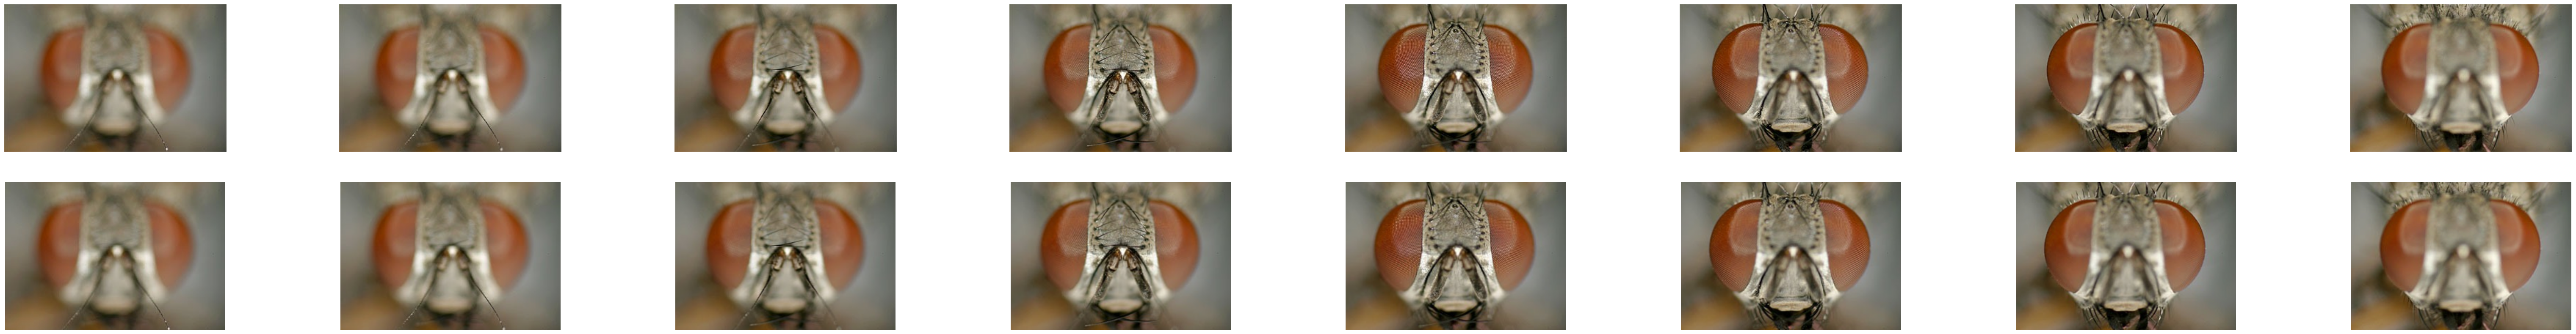

In [6]:
# Code adapted from https://learnopencv.com/image-alignment-ecc-in-opencv-c-python/
def align_images(images: np.array, num_iter=1000, term_eps=1e-5, warp_mode=cv2.MOTION_HOMOGRAPHY) -> np.array:
    '''
    Aligns images using the ECC algorithm

    images - numpy array representing list of images to align
    num_iter - maximum number of alignment iterations
    term_eps - epsilon value for min change between alignment iterations (if less, terminates)
    warp_mode - type of transformation to calculate alignment with

    returns - numpy array of aligned images
    '''
    assert len(images) > 1  # At least 2 images to align
    assert len(images.shape) == 4 # Expect images in color
    assert images.shape[3] == 3
    assert warp_mode in [cv2.MOTION_HOMOGRAPHY,  # Possible warp modes
                         cv2.MOTION_EUCLIDEAN,
                         cv2.MOTION_AFFINE,
                         cv2.MOTION_HOMOGRAPHY]

    ref_img = images[0]
    ref_gray = rgb_to_gray(ref_img)
    height, width, _ = ref_img.shape

    ref_corners = np.array([
        [0,       0,        1],
        [width-1, 0,        1],
        [0,       height-1, 1],
        [width-1, height-1, 1],
    ])

    aligned = [ref_img]
    new_corners = [ref_corners[:, :-1]]

    for i, img in enumerate(list(images[1:])):
        print(f"Align Image {i + 2}")
        img_gray = rgb_to_gray(img)

        # Define 2x3 or 3x3 matrices and initialize the matrix to identity
        if warp_mode == cv2.MOTION_HOMOGRAPHY:
            warp_matrix = np.eye(3, 3, dtype=np.float32)
        else:
            warp_matrix = np.eye(2, 3, dtype=np.float32)

        # Define termination criteria
        criteria = (cv2.TERM_CRITERIA_EPS |
                    cv2.TERM_CRITERIA_COUNT, num_iter, term_eps)

        # Run the ECC algorithm. The results are stored in warp_matrix.
        _, warp_matrix = cv2.findTransformECC(
            ref_gray, img_gray, warp_matrix, warp_mode, criteria)

        if warp_mode == cv2.MOTION_HOMOGRAPHY:
            # Use warpPerspective for Homography
            img_aligned = cv2.warpPerspective(
                img, warp_matrix, (width, height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
        else:
            # Use warpAffine for Translation, Euclidean and Affine
            img_aligned = cv2.warpAffine(
                img, warp_matrix, (width, height), flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)

        if warp_mode != cv2.MOTION_HOMOGRAPHY:
            warp_matrix = np.vstack((warp_matrix, np.array([0, 0, 1])))

        # Calculate corners of warped image
        inv_warp = np.linalg.inv(warp_matrix)
        corners = ref_corners @ inv_warp.T
        corners = (corners.T / corners[:, -1])[:-1].T

        new_corners.append(corners)
        aligned.append(img_aligned)

    # Calculate and apply crop
    new_corners = np.array(new_corners)
    tl_x = new_corners[:, 0, 0]
    tl_y = new_corners[:, 0, 1]
    tr_x = new_corners[:, 1, 0]
    tr_y = new_corners[:, 1, 1]
    bl_x = new_corners[:, 2, 0]
    bl_y = new_corners[:, 2, 1]
    br_x = new_corners[:, 3, 0]
    br_y = new_corners[:, 3, 1]

    tl_x = math.ceil(np.max([tl_x, bl_x]))
    tl_y = math.ceil(np.max([tl_y, tr_y]))
    br_x = math.floor(np.min([br_x, tr_x]))
    br_y = math.floor(np.min([br_y, bl_y]))
    aligned = [img[tl_y:br_y, tl_x:br_x] for img in aligned]

    return np.array(aligned)


aligned = align_images(images)
fig, ax = plt.subplots(2, len(aligned), figsize=(len(aligned) * 10, 10))
for i in range(len(aligned)):
    plt_img(ax[0, i], images[i])
    plt_img(ax[1, i], aligned[i])

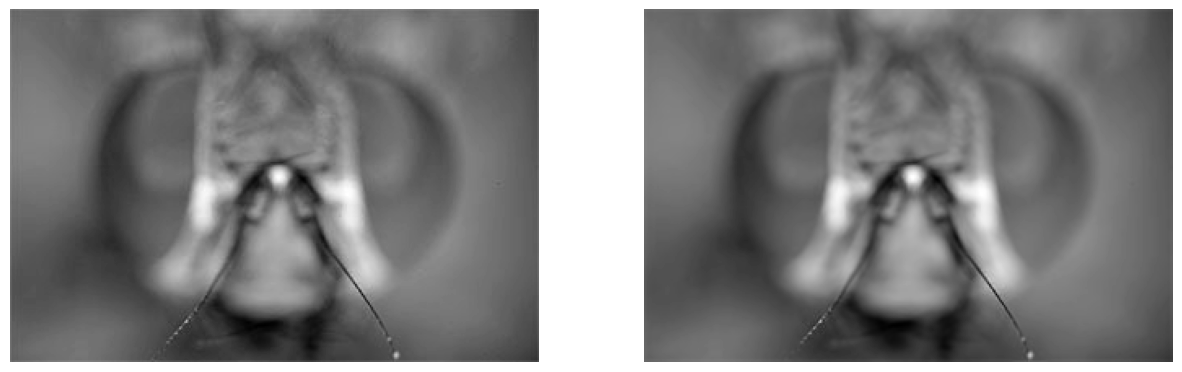

In [7]:
def denoise_image(img: np.array, template_win_size=7, search_win_size=21, filter_strength=10) -> np.array:
    '''
    Denoises a given image

    img - image to denoise
    template_win_size - Size in pixels of the template patch that is used to compute weights. Should be odd. Recommended value 7 pixels 
    search_win_size - Size in pixels of the window that is used to compute weighted average for given pixel. Should be odd. 
                      Affect performance linearly: greater searchWindowsSize - greater denoising time. Recommended value 21 pixels 
    filter_strength - Denoising strength. Higher value removes more noise but removes details.

    returns - numpy array representing denoised image
    '''
    # Window sizes must be odd
    assert template_win_size % 2 == 1
    # Window sizes must be odd
    assert search_win_size % 2 == 1
    # Grayscale or RGB images allowed
    assert len(img.shape) == 2 or len(img.shape) == 3

    img = cv2.fastNlMeansDenoising(
        img, None, template_win_size, search_win_size, filter_strength
    )
    return img


img = images[1]
gray = normalize_array(rgb_to_gray(img), uint8_mode=True)
denoised = denoise_image(gray, 7, 21, 3)

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
plt_img(ax[0], gray)
plt_img(ax[1], denoised)

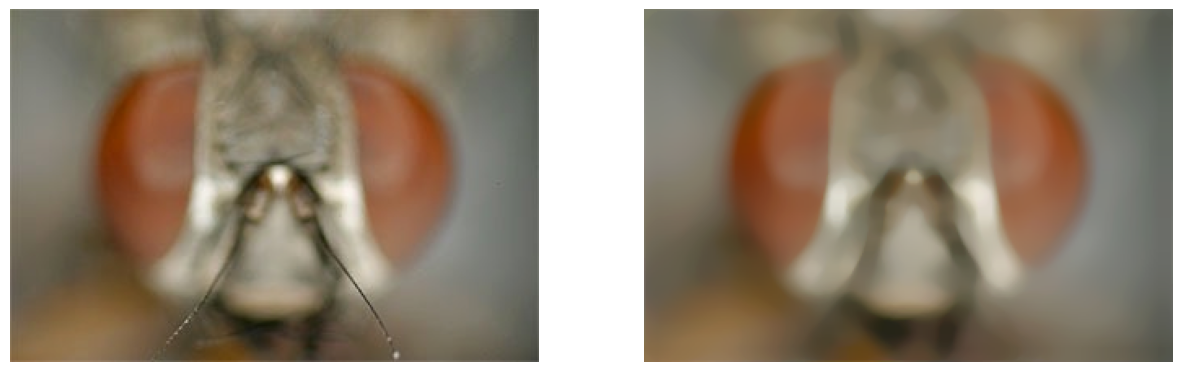

In [8]:
def smooth_image(img: np.array, kernel_size=7) -> np.array:
    '''
    Smoothes given image with a median blur

    img - numpy array of RGB or grayscale image
    kernel_size - Size in pixels of median blur kernel

    returns - numpy array representing smoothed image
    '''
    # Kernel size must be odd
    assert kernel_size % 2 == 1
    # Grayscale or RGB images allowed
    assert len(img.shape) == 2 or len(img.shape) == 3

    img = cv2.medianBlur(img, kernel_size)
    return img


img = images[1]
smoothed = smooth_image(normalize_array(img, uint8_mode=True), 15)

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
plt_img(ax[0], img)
plt_img(ax[1], smoothed)

1. Aligning Images
Align Image 2
Align Image 3
Align Image 4
Align Image 5
Align Image 6
Align Image 7
Align Image 8
2. Calculating Sharpness Ranking
3. Smoothing Depth Map
4. Stacking Images


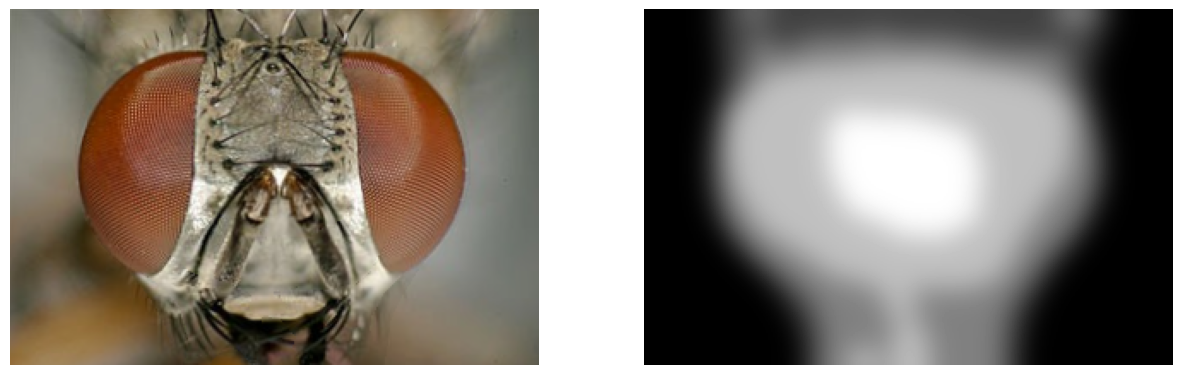

In [9]:
class DepthMapArgs:
    # Arguments for alignment of input images
    align_max_iters = 1000
    align_epsilon = 1e-5
    align_warp_mode = cv2.MOTION_HOMOGRAPHY

    # Arguments for denoising input images
    denoise_temp_win_size = 7
    denoise_search_win_size = 21
    denoise_strength = 3

    # Arguments for calculating sharpness values
    gaussian_kernel_size = 3
    laplacian_kernel_size = 3

    # Arguments for calcuating background mask
    bg_mask_denoise_strength = 50
    bg_thresh = 0.15  # std from average sharpness, under which to count as bg

    # Arguments for denoising and smoothing depth map
    map_max_pool_size = 3
    map_denoise_temp_win_size = 7
    map_denoise_search_win_size = 21
    map_denoise_strength = 5
    map_smooth_kernel_size = 51
    map_blur_kernel = 51


def sharpness_vals(image: np.array, args: DepthMapArgs) -> np.array:
    '''
    Calculates sharpness rankings of given image using Laplacian of Gaussian kernel
    Converts image to grayscale, denoises image, and then runs a LoG kernel over image

    image - numpy array of RGB image to calculate sharpness values of
    args - tuneable arguments for depth mapping algorithm. See DepthMapArgs class

    returns - 2d numpy array of sharpness rankings, higher = sharper
    '''
    assert args.gaussian_kernel_size % 2 == 1  # ksize must be odd
    assert args.laplacian_kernel_size % 2 == 1  # ksize must be odd

    temp_win = args.denoise_temp_win_size
    search_win = args.denoise_search_win_size
    denoise_strength = args.denoise_strength

    gray = normalize_array(rgb_to_gray(image), uint8_mode=True)
    denoise = denoise_image(gray, temp_win, search_win, denoise_strength)
    blur = gauss_convolve(denoise, args.gaussian_kernel_size)
    sharp = laplacian_convolve(blur, args.laplacian_kernel_size)

    return sharp


def depth_mapping(images: np.array, focal_depths: np.array, args=DepthMapArgs()) -> tuple[np.array, np.array, tuple[np.array, np.array, np.array]]:
    '''
    Computes depth map and focus stacked image from given images and focal_depths

    images - array of grayscale or RGB images
    focal_depths - numpy array of focal depths (indexwise match with images)
    args - tuneable arguments for depth mapping algorithm. See DepthMapArgs class

    returns - tuple of depth map (2D uint8 numpy array), focus stacked image (numpy array simplar to images[0]), and tuple of intermediate steps
    intermediate steps include:
      np.array of aligned images (num images, height, width, color)
      np.array of images of sharpness rankings (num images, height, width, color)
      np.array of background mask (height, width)
    '''
    assert len(images.shape) == 4  # Expect list of RGB images

    # Focal depths should be unique and sorted
    assert np.sum(np.unique(focal_depths) != focal_depths) == 0

    print("1. Aligning Images")
    images = align_images(images, args.align_max_iters,
                          args.align_epsilon, args.align_warp_mode)

    # Normalize depths according to paper: I * (f_max - f_min) / N
    norm = (np.max(focal_depths) - np.min(focal_depths)) / len(focal_depths)
    focal_depths = focal_depths * norm

    # Calculate sharpness ranking of images
    print("2. Calculating Sharpness Ranking")
    sharpness_ranking = np.array([sharpness_vals(img, args) for img in images])

    # Use image index as proxy for depth for now
    _, height, width = sharpness_ranking.shape

    depth_index = np.zeros((height, width), dtype='uint8')

    print("3. Smoothing Depth Map")
    tile_size = args.map_max_pool_size
    temp_win = args.map_denoise_temp_win_size
    search_win = args.map_denoise_search_win_size
    denoise_strength = args.map_denoise_strength

    # Max pool depths
    if (tile_size == 1):
        depth_index = np.argmax(sharpness_ranking, axis=0).astype('uint8')
    else:
        for tile_r in range(0, height - tile_size + 1, tile_size):
            for tile_c in range(0, width - tile_size + 1, tile_size):
                tile_sharp = sharpness_ranking[
                    :,
                    tile_r: tile_r+tile_size,
                    tile_c: tile_c+tile_size
                ]

                # For each tile, find the maximum sharpness in that tile
                # Set depth of entire tile to that maximum sharpness
                max_sharp_index = 0
                max_sharp_val = np.max(tile_sharp[0])
                for i in range(1, tile_sharp.shape[0]):
                    if np.max(tile_sharp[i]) > max_sharp_val:
                        max_sharp_index = i
                        max_sharp_val = np.max(tile_sharp[i])

                for r in range(tile_r, tile_r + tile_size):
                    for c in range(tile_c, tile_c + tile_size):
                        depth_index[r, c] = max_sharp_index

    mean_sharp = np.mean(sharpness_ranking, axis=0)
    bg_mask = np.zeros_like(depth_index, dtype='uint8')
    for h in range(height):
        for w in range(width):
            bg_mask[h, w] = abs(
                sharpness_ranking[depth_index[h, w], h, w] - mean_sharp[h, w]
            )

    bg_mask = bg_mask.astype('uint8')
    bg_mask = denoise_image(
        bg_mask, temp_win, search_win, args.bg_mask_denoise_strength)
    if (args.map_smooth_kernel_size > 1):
        bg_mask = smooth_image(bg_mask, args.map_smooth_kernel_size)

    bg_mask = bg_mask < args.bg_thresh * np.std(sharpness_ranking)
    labels = skimage.measure.label(bg_mask)
    bg_labels = labels * bg_mask
    bg_labels = np.unique(
        np.concatenate(
            [bg_labels[0], bg_labels[-1], bg_labels[:, 0], bg_labels[:, -1]]
        )
    )
    bg_labels = bg_labels[bg_labels != 0]

    bg_mask = np.zeros_like(depth_index)
    for label in bg_labels:
        bg_mask += labels == label

    depth_index = (1 - bg_mask) * depth_index \
        + bg_mask * np.max(depth_index)

    # Denoise depth map
    depth_index = denoise_image(
        depth_index, temp_win, search_win, denoise_strength)

    # Smooth out depths with a median blur
    if (args.map_smooth_kernel_size > 1):
        depth_index = smooth_image(depth_index, args.map_smooth_kernel_size)

    # Scale so that 0 is the furthest point, 255 is the closest
    depth_map = focal_depths[depth_index]
    depth_map = 255 - normalize_array(depth_map, uint8_mode=True)

    # Blur map to avoid stairstepping depth
    depth_map = gauss_convolve(depth_map, args.map_blur_kernel)

    # Calculate masks and generate stacked image
    print("4. Stacking Images")
    stacked = np.zeros_like(images[0])
    for i in range(len(focal_depths)):
        mask = depth_index == i
        stacked += np.repeat(mask[..., None],
                             images.shape[3], axis=2) * images[i]

    return depth_map, stacked, (images, sharpness_ranking, bg_mask)


depth, stack, intermediates = depth_mapping(images, focal_depths)
aligned, sharpness, bg_mask = intermediates

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
plt_img(ax[0], stack)
plt_img(ax[1], depth)

In [10]:
save_img('./stack.png', stack)
save_img('./depth.png', depth)

# Visualize on https://depthplayer.ugocapeto.com/ or https://depthmapviewer.ugocapeto.com/

Image saved at c:\Users\Bennett\Documents\Documents\1. School\2. Fall 2023\CS 445\Final Project\focus-stacking\depth_mapping\stack.png
Image saved at c:\Users\Bennett\Documents\Documents\1. School\2. Fall 2023\CS 445\Final Project\focus-stacking\depth_mapping\depth.png
